In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['figure.dpi'] = 150
import copy
from scipy.spatial import Delaunay
from collections import defaultdict
import random
import elkai
from functools import partial
import time
import ray
import psutil
from scipy import optimize
from scipy import interpolate
import pyecharts.options as opts
from pyecharts.charts import Scatter3D
import open3d as o3d

### Functions 

In [2]:
# functions

# calculate specks of circle
# input: rmax, maximum radius; rmin, minimum radius; area, maximum area of each speck
# output: s_set, a list of the area of specks; p_set, a list of the center of each speck
def circle_di(rmax, rmin, area, show = False):
    a = area**0.5
    nr = np.floor((rmax-rmin)/a)
    r = np.arange(rmin,rmax + (rmax-rmin)/(nr+1),(rmax-rmin)/nr)
    if show:
        for tr in r:
            tn = 100
            angle = np.arange(0,2*np.pi+2*np.pi/(tn+1),2*np.pi/tn)
            x = tr*np.cos(angle)
            y = tr*np.sin(angle)
            plt.plot(x,y,'b')

    theta_set = []
    s_set = []
    p_set = []
    for i in range(r.shape[0]-1):
        tr1 = r[i]
        tr2 = r[i+1]
        ts = np.pi*(tr2**2-tr1**2)
        tn = np.ceil(ts/area)
        theta = np.arange(0,2*np.pi+2*np.pi/(tn+1),2*np.pi/tn)
        if show:
            for ttheta in theta:
                plt.plot([tr1*np.cos(ttheta), tr2*np.cos(ttheta)],[tr1*np.sin(ttheta), tr2*np.sin(ttheta)],'b')
        for j in range(len(theta)-1):
            ttheta = (theta[j]+theta[j+1])/2
            tr = (tr1+tr2)/2
            p_set.append([tr*np.cos(ttheta),tr*np.sin(ttheta)])
            if show:
                plt.scatter(p_set[-1][0],p_set[-1][1],s = 1,color = 'r')
        theta_set.append(theta)
        s_set.extend([ts*(theta[1]-theta[0])/2/np.pi]*(len(theta)-1))
    return s_set, p_set

# calculate the connected points and triangles
# input: tri, nx3 index
# output: dic_tri_connected, dic_point_connected, dictionary whose values are indices of connected elements
def cal_connection(tri):
    dic_point_connected = {}
    dic_tri_connected = {}
    for i in range(tri.shape[0]):
        ttri = tri[i,:]
        edge = [[ttri[0],ttri[1]],[ttri[0],ttri[2]],[ttri[1],ttri[2]]]
        for j in range(3):
            a = edge[j][0]
            b = edge[j][1]
            if a not in dic_point_connected:
                dic_point_connected[a] = [b]
            else:
                if b not in dic_point_connected[a]:
                    dic_point_connected[a].append(b)
            if b not in dic_point_connected:
                dic_point_connected[b] = [a]
            else:
                if a not in dic_point_connected[b]:
                    dic_point_connected[b].append(a)
        if dic_tri_connected == {}:
            dic_tri_connected[0] = []
        else:
            for j in range(3):
                a = ttri[j]
                row = np.where(tri[:i,:] == a)[0]
                if row.shape[0] > 0 :
                    for tr in row:
                        if i not in dic_tri_connected[tr]:
                            dic_tri_connected[tr].append(i)
                        if i not in dic_tri_connected:
                            dic_tri_connected[i] = [tr]
                        else:
                            if tr not in dic_tri_connected[i]:
                                dic_tri_connected[i].append(tr)
    return dic_tri_connected, dic_point_connected

# whether a point p is in the triangle
# input: p, nx1; triangle, [p1,p2,p3]
# output: True or False
def if_in_tri(triangle,p):
    # nx1 array
    p1,p2,p3 = triangle
    s1 = np.cross(p1-p,p2-p1)
    s2 = np.cross(p2-p,p3-p2)
    s3 = np.cross(p3-p,p1-p3)
    if s1 >=0 and s2 >= 0 and s3>=0:
        return True
    elif s1 <=0 and s2 <= 0 and s3<=0:
        return True
    else:
        return False
#     if np.sign(np.cross(p2-p1,p-p1))*np.sign(np.cross(p2-p1,p3-p1)) >= 0:
#         if np.sign(np.cross(p3-p2,p-p2))*np.sign(np.cross(p3-p2,p1-p2)) >= 0:
#             if np.sign(np.cross(p1-p3,p-p3))*np.sign(np.cross(p1-p3,p2-p3)) >= 0:
#                 return True
    return False

def if_in_quad(quad, p):
    [p1,p2,p3,p4] = quad
    s1 = np.cross(p1-p,p2-p1)
    s2 = np.cross(p2-p,p3-p2)
    s3 = np.cross(p3-p,p4-p3)
    s4 = np.cross(p4-p,p1-p4)
    if s1 >=0 and s2 >= 0 and s3>=0 and s4 >=0:
        return True
    elif s1 <=0 and s2 <= 0 and s3<=0 and s4 <=0:
        return True
    else:
        return False


# calculate the depth from each point of disk to workpiece in the disk frame
# input: p_set, 3xn coordinates of disk points; AllPoints_array_CorInDisk, 3xn workpiece points; tri, nx3 index;dic_point_connected, index dic;
#        dic_tri_connected, index dic; radius_plane_estimate, radius to fit the plane
# output: h, a list of depths
def cal_depth(p_set, AllPoints_array_CorInDisk, radius_plane_estimate, show_procedure = False):
    inf = 100000
    h = []
    radius_for_depth = (np.max(p_set) - np.min(p_set))/2 + radius_plane_estimate
    workpiece_index = []
    r_set = []

    tr_set = np.linalg.norm(AllPoints_array_CorInDisk[:2,:],axis = 0)
    workpiece_index = list(np.where(tr_set < radius_for_depth)[0])
    NewPoints = AllPoints_array_CorInDisk[:,workpiece_index]
    r_set = tr_set[workpiece_index]

    for i in range(p_set.shape[1]):
        p = p_set[:2,i]
        tr_dicretep_set = np.linalg.norm(NewPoints[:2,:] - p.reshape(2,1),axis = 0)
        fit_index = np.where(tr_dicretep_set < radius_plane_estimate)[0]
        plane_p_set = NewPoints[:2, fit_index]
        z_set = NewPoints[2,fit_index]
        
        if plane_p_set.shape[1] >= 3:
            angle = []
            for j in range(plane_p_set.shape[1]):
                tp = plane_p_set[:,j]
                angle.append(np.arctan2(tp[1]-p[1],tp[0]-p[0]))
            angle = np.sort(angle)
            
            flag_in = True
            if angle[-1] - angle[0] < np.pi:
                flag_in = False
            else:
                for j in range(angle.shape[0]-1):
                    if angle[j+1]-angle[j] >np.pi:
                        flag_in = False
                        break
            if flag_in:
                plane_p_set = np.hstack((plane_p_set.T,np.ones(shape=(plane_p_set.shape[1],1))))
                z_set = z_set.reshape(z_set.shape[0],1)
                z_plane = np.asarray([0])
                P = plane_p_set.T.dot(plane_p_set)
                c = np.linalg.inv(P).dot(plane_p_set.T).dot(z_set)    
                z_plane = np.asarray([p[0],p[1],1]).dot(c)
                h.append(z_plane[0])
            else:
                h.append(-inf)
        else:
            h.append(-inf)
    return h, workpiece_index, r_set

# calculate the grinding force
# input: h, depth set, array; s, area set, array; E, MPa; H, m; Beta, coefficient
# output: normal force, N
def cal_force(h,s,E,H,Beta):
    return (E*((h>0)*h/H)**Beta).dot(s)

# calculate the grinding force
# input: F_desired, desired force, N; h, depth set, array; s, area set, array or list; E, MPa; H, m; Beta, coefficient
# output: d, mm
def cal_d_from_F(F_desired, h, s_set, E, H, Beta, d = 2, dd = 0.1, tolerance = 0.1, iteration_loop = 200):
    d = 2
    dd = 0.1
    tolerance = 0.1
    count = 0
    success = False
    while 1:
        f1 = cal_force(h+d,s_set,E,H,Beta) - F_desired
        f2 = cal_force(h+d+dd,s_set,E,H,Beta) - F_desired
        if abs(f2 - f1) < 10**(-8):
            return 0, False
        d = d - f1/(f2-f1)*dd
        count += 1
        if abs(f1) < tolerance:
            success = True
            break
        elif count > iteration_loop:
            success = False
            break
    return d, success

# calculate the rotation matrix through eular angles. order, xyz
# input: pitch, x axis; yaw, y axis; roll, z
# output: rotation matrix
def R_from_angles(pitch, yaw, roll):
    Rx = np.asarray([[1,0,0],[0, np.cos(pitch), - np.sin(pitch)], [0, np.sin(pitch), np.cos(pitch)]])
    Ry = np.asarray([[np.cos(yaw),0,np.sin(yaw)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])
    Rz = np.asarray([[np.cos(roll), -np.sin(roll),0],[np.sin(roll), np.cos(roll),0],[0,0,1]])
    return Rz.dot(Ry).dot(Rx)

# calculate the rotaion matrix representing the frame whose z axis is normal of workpiece point
# input: fd, feed direction (x axis), (2,) array, (x,y); normal, normal direction, (3,)
# output: rotation matrix
def R_from_fd_and_normal(fd, normal):
    x,y = fd
    a = normal[0]*x +normal[1]*y
    b = normal[2]
    if a != 0 and b != 0:
        k = -b/a
        z = 1
        if k < 0 :
            k = -k
            z = -1
    elif a ==0 and b != 0:
        k = 1
        z = 0
    elif a != 0 and b == 0:
        k = 0
        z = 1
    else:
        print('The surface is vertical. ')
        return None
    x_axis = np.asarray([x*k,y*k,z])
    x_axis = x_axis/np.linalg.norm(x_axis)
    y_axis = np.cross(normal,x_axis)
    Rt = np.asarray([x_axis,y_axis,normal])
    return Rt.T

### Analytical functions of the upper surface: Z coordinates and normals.
def fun_plane(x,y):
    r = (x**2+y**2)**0.5
    if r < 55 :
        z = 60
    else:
        z = 60+550/29-10/29*r
    return z

def fun_plane_normal(x,y):
    r = (x**2+y**2)**0.5
    if r < 55:
        tv = np.asarray([0,0,1])
    else:
        tv = np.asarray([50,0,145])
    theta = np.arctan2(y,x)
    R = R_from_angles(0,0, theta)
    v = R.dot(tv.reshape(3,1)).reshape(3)
    v = v/np.linalg.norm(v)
    return v

### remote function to simulate the grinding
@ray.remote(num_returns=3)
def grinding_point(p_contacted, angles, R, F_desired, dt, p_set, AllPoints_array, radius_plane_estimate, ModelParameter):
    E, H, Beta, K,Omega = ModelParameter
    pitch, yaw, roll = angles
    R_disk = R.dot(R_from_angles(pitch,yaw,roll))
    p_disk = R_disk.dot(np.asarray([[rmax],[0],[0]]))+p_contacted
    # rotate the disk
    p_set_CorInPlane = R_disk.dot(p_set) + p_disk

    # workpiece coordinates in the disk frame
    AllPoints_array_CorInDisk = R_disk.T.dot(AllPoints_array.T)-R_disk.T.dot(p_disk)
    h, workpiece_index, r_set = cal_depth(p_set, AllPoints_array_CorInDisk, radius_plane_estimate)
    h = np.asarray(h)
    d, _ = cal_d_from_F(F_desired, h, s_set, E, H, Beta, d = 2, dd = 0.1, tolerance = 0.1, iteration_loop = 200)
    # reward means grinding depth. scale is the ratio between grinding depth and reward.
    new_f_workpiece_index = []
    removal = []
    for i in range(len(workpiece_index)):
        if r_set[i] < disk_R:
            th = AllPoints_array_CorInDisk[2,workpiece_index[i]]
            th += d
            tr = r_set[i]
            if th > 0:
                pressure = E*(th/H)**Beta
                slide_speed=Omega*tr
                removal.append(K*pressure*slide_speed*dt)
                new_f_workpiece_index.append(workpiece_index[i])
    return new_f_workpiece_index, removal,d

### Expected removal
def fun_reward(x,y,c):
    r = c[0]*x*x + c[1]*y*y + c[2]*x*y + c[3]*x + c[4]*y + c[5]
    return r

### Extract the point cloud of each subsurface
def subsurface(area_id):
    spoke = spoke_list[area_id] # 73 177
    bp1 = [spoke[0][0]*(np.cos(spoke[1][0])+np.cos(spoke[2][0]))/2,spoke[0][0]*(np.sin(spoke[1][0])+np.sin(spoke[2][0]))/2]
    bp2 = [spoke[0][-1]*(np.cos(spoke[1][-1])+np.cos(spoke[2][-1]))/2,spoke[0][-1]*(np.sin(spoke[1][-1])+np.sin(spoke[2][-1]))/2]
    
    n = 30
    y1 = [spoke[0][index]*np.cos(spoke[1][index]) for index in range(len(spoke[0]))]
    z1 = [spoke[0][index]*np.sin(spoke[1][index]) for index in range(len(spoke[0]))]
    y2 = [spoke[0][index]*np.cos(spoke[2][index]) for index in range(len(spoke[0]))]
    z2 = [spoke[0][index]*np.sin(spoke[2][index]) for index in range(len(spoke[0]))]
    # plt.scatter(y1+y2,z1+z2,s = 5, color = 'k')
    r1 = spoke[0][0]
    r2 = spoke[0][-1]
    theta1i = spoke[1][0]
    theta1a = spoke[2][0]
    theta2i = spoke[1][-1]
    theta2a = spoke[2][-1]
    if theta1a < theta1i:
        theta1a += np.pi*2
    if theta2a < theta2i:
        theta2a += np.pi*2
    angle1 = np.linspace(theta1i, theta1a, n)
    angle2 = np.linspace(theta2i, theta2a, n)
    arc1 = [r1*np.cos(angle1),r1*np.sin(angle1)]
    arc2 = [r2*np.cos(angle2),r2*np.sin(angle2)]
    # plt.plot(arc1[0], arc1[1], color = 'k', linewidth = 1)
    # plt.plot(arc2[0], arc2[1], color = 'k', linewidth = 1)
    # plt.xlabel('x/mm')
    # plt.ylabel('y/mm')
    # plt.axis('equal')

    points_spoke = []
    points_spoke_polar = []
    remain_index = []
    for i in range(points_yz_polar.shape[0]):
        if points_yz_polar[i,0] < spoke[0][-1] and points_yz_polar[i,0]>=spoke[0][0]:
            for j in range(len(spoke[0])):
                if points_yz_polar[i,0]>= spoke[0][j]:
                    continue
                else:
                    if points_yz_polar[i,1] <= np.max([spoke[2][j],spoke[2][j-1]]) and points_yz_polar[i,1] >= np.min([spoke[1][j],spoke[1][j-1]]):
                        points_spoke.append(points_yz[i,:])
                        points_spoke_polar.append(points_yz_polar[i,:])
                        remain_index.append(i)
                        break
    points_spoke = np.asarray(points_spoke)
    # plt.scatter(points_spoke[:,0],points_spoke[:,1],s = 1)
    # plt.axis('equal')
    # plt.show()

    pcd_spoke = pcd.select_by_index(remain_index)

    AllPoints = np.asarray(pcd_spoke.points)
    AllNormals = np.asarray(pcd_spoke.normals)

    workpiece_pcd = o3d.geometry.PointCloud()  
    AllPoints_array = np.asarray(AllPoints)
    AllNormals_array = np.asarray(AllNormals)
    color = np.asarray([[0],[0],[0]])
    workpiece_pcd.points = o3d.utility.Vector3dVector(AllPoints_array)
    workpiece_pcd.normals = o3d.utility.Vector3dVector(AllNormals_array)
    workpiece_pcd.paint_uniform_color(color)  

    # triangle mesh for the plane. using 3d alphashape
    radii = [1,2,4,8]
    rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        workpiece_pcd, o3d.utility.DoubleVector(radii))
    tri = np.asarray(rec_mesh.triangles)

    # disk  
    s_set, p_set = circle_di(rmax, rmin, area, show = False)
    s_set = np.asarray(s_set)
    p_set = np.asarray(p_set).T
    p_set = np.vstack((p_set,np.zeros(shape=(1,p_set.shape[1]))))
    # array, 3xn
    return AllPoints_array, AllNormals_array, p_set, s_set


### simulate the removal based on the optimized parameters (path and velocity)
def grinding_simulator(AllPoints_array, AllNormals_array, p_set, s_set):
    reward_array = np.zeros(shape = (AllPoints_array.shape[0] , 1))
    c_surface = [0,0,0,0,0,1]
    for i in range(AllPoints_array.shape[0]):
        reward_array[i,0] = fun_reward(AllPoints_array[i,0],AllPoints_array[i,1],c_surface)
    if np.max(reward_array)-np.min(reward_array) != 0:
        reward_array = (reward_array-np.min(reward_array))/(np.max(reward_array)-np.min(reward_array))
    else:
        reward_array = reward_array/np.max(reward_array)
    reward_array = reward_array/2 + 0.5
    initial_reward_array = copy.deepcopy(reward_array)
    reward_array = copy.deepcopy(initial_reward_array)*scale

    AllPoints_array_id = ray.put(AllPoints_array)
    p_set_id = ray.put(p_set)

    for i in range(path_point_set_set[area_id].shape[0]):
        path_point = path_point_set_set[area_id][i]
        ts_set = ts_set_set[area_id][i]
        p_contacted_set = []
        fd_set = []
        for i in range(len(path_point)-1):
            p_contacted_set.append((path_point[i]+path_point[i+1])/2)
            tfd = (path_point[i+1]-path_point[i])[:2,0]
            fd_set.append(tfd/np.linalg.norm(tfd))

        R_set = []
        for i in range(len(p_contacted_set)):
            z_axis = fun_plane_normal(p_contacted_set[i][0,0],p_contacted_set[i][1,0])
            R = R_from_fd_and_normal(fd_set[i],z_axis)
            R_set.append(R)

        dt = 1
        f_workpiece_index_ids = []
        removal_ids = []
        d_ids = []

        for i in range(len(p_contacted_set)):
            ids = grinding_point.remote(p_contacted_set[i], angles, R_set[i], F_desired, dt, p_set_id, AllPoints_array_id, radius_plane_estimate, 
                                        ModelParameter_id)
            f_workpiece_index_ids.append(ids[0])
            removal_ids.append(ids[1])
            d_ids.append(ids[2])

        f_workpiece_index = ray.get(f_workpiece_index_ids)
        removal = ray.get(removal_ids)
        d = ray.get(d_ids)

        for i in range(len(f_workpiece_index)):
            for j in range(len(f_workpiece_index[i])):
                reward_array[f_workpiece_index[i][j], 0] -= removal[i][j]*ts_set[i]
    return reward_array

### Upper surface to be ground

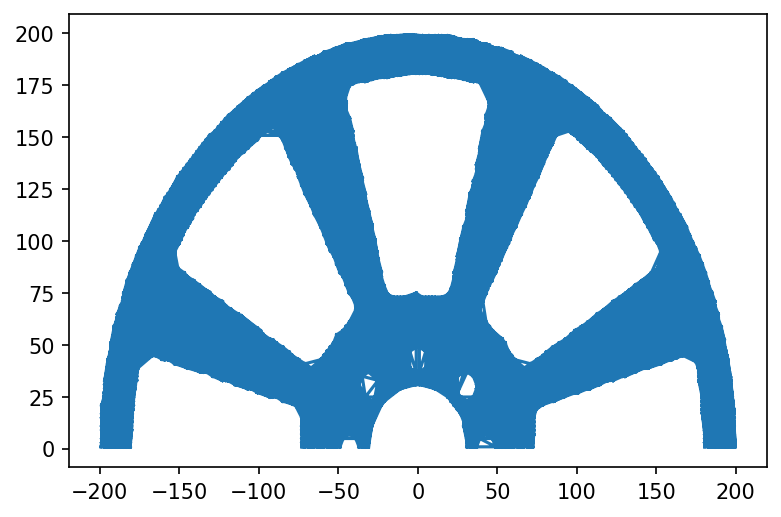

In [3]:
pcd = o3d.io.read_point_cloud("Model_Data/Wheel_upper_surface.ply")
pcd.normalize_normals()
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=50, origin=[0,0,0])
# o3d.visualization.draw_geometries([pcd,mesh_frame],
#                                   zoom=0.3412,
#                                   front=[0.4257, -0.2125, -0.8795],
#                                   lookat=[2.6172, 2.0475, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024],
#                                   point_show_normal=True) 
points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)
new_tri_set = np.load('Model_Data/new_tri_set.npy')

# tri_set after alpha_shape
final_contour = np.load('Model_Data/final_contour.npy',allow_pickle= True)
final_contour = list(final_contour)
# point index set of a contour
points_yz = points[:,:2]

plt.triplot(points_yz[:,0],points_yz[:,1],new_tri_set)

final_contour_points = []

for i in range(len(final_contour)):
    x = [points_yz[j][0] for j in final_contour[i]]
    y = [points_yz[j][1] for j in final_contour[i]]
    final_contour_points.append([x,y])
#     plt.plot(x,y,color = 'k')
# plt.axis('equal')
# plt.xlabel('x/mm')
# plt.ylabel('y/mm')
# plt.show()

bound_y = [np.min(points_yz[:,0]), np.max(points_yz[:,0])]
bound_z = [np.min(points_yz[:,1]), np.max(points_yz[:,1])]
center = np.asarray([0,0])
final_contour_points_polar = []
contour_bounds_polar = []
for i in range(len(final_contour)):
    r = [np.linalg.norm(points_yz[index,:] - center) for index in final_contour[i]]
    theta = [np.arctan2((points_yz[index,:] - center)[1],(points_yz[index,:] - center)[0]) for index in final_contour[i]]
    final_contour_points_polar.append([r,theta])
    contour_bounds_polar.append([np.min(r),np.max(r),np.min(theta),np.max(theta)])

ta = np.asarray(contour_bounds_polar)

points_yz_polar = []
for i in range(points_yz.shape[0]):
    r = np.linalg.norm(points_yz[i,:])
    theta = np.arctan2(points_yz[i,1],points_yz[i,0])
    points_yz_polar.append([r,theta])
points_yz_polar = np.asarray(points_yz_polar)

### Physical Parameters

In [4]:
# parameters 
E = 0.84  # modulus /MPa 
Beta = 0.89 # power index
H = 10  # mm disc thickness 
K = 0.0453  # μm material removal coefficient 
disk_R = 37.5 # mm %tool radius /m
Tilt_angle = 12*np.pi/180
Omega = 2*np.pi*5000/60 # 3000r /min
feedrate = 50 # feedrate=50; % mm/s

### Boundary of each subsurface

In [5]:
spoke_list = []
for i in range(6):
    spoke_list.append(np.load('Model_Data/spoke'+str(i)+'.npy')) # [[r,....],[theta1,...],[theta2,...]]

### Initialize

In [6]:
area = 4
rmax = disk_R
rmin = 1 
num_cpus = 3
radius_plane_estimate = 5
pitch = 0
yaw = - Tilt_angle
roll = 0
angles = [pitch,yaw,roll]
F_desired = 12
ray.init(num_cpus = num_cpus, ignore_reinit_error=True)
ModelParameter = [E, H, Beta, K,Omega]
ModelParameter_id = ray.put(ModelParameter)
step = 1
amplifier = 100
scale = 100
amax = 10
vmax = 50 # should be big enough

ts_set_set = []
path_point_set_set = []
r_set_set = []
for i in range(6):
    ts_set_set.append(np.load('Model_Data/ex4_ts_set_spoke'+str(i)+'.npy',allow_pickle=True))
    path_point_set_set.append(np.load('Model_Data/ex4_pathpoint_set_spoke'+str(i)+'.npy', allow_pickle=True))
    r_set_set.append(np.load('Model_Data/ex4_r_set_spoke'+str(i)+'.npy'))

2021-03-05 14:53:57,845	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265


### Simulate the removal for each subsurface

In [7]:
AllPoints_array_list = []
reward_array_list = []
for area_id in range(6):
    if area_id == 5:
        step = 3
    AllPoints_array, AllNormals_array, p_set, s_set = subsurface(area_id)
    reward_array = grinding_simulator(AllPoints_array, AllNormals_array, p_set, s_set)
    AllPoints_array_list.append(AllPoints_array)
    reward_array_list.append(reward_array)
    
AllPoints_array = copy.deepcopy(AllPoints_array_list[0])
reward_array = copy.deepcopy(reward_array_list[0])
for i in range(1,6):
    AllPoints_array = np.vstack((AllPoints_array,AllPoints_array_list[i]))
    reward_array = np.vstack((reward_array,reward_array_list[i]))

### Plot

In [8]:
import pyecharts.options as opts
from pyecharts.charts import Scatter3D


# 配置 config
config_xAxis3D = "x"
config_yAxis3D = "y"
config_zAxis3D = "reward"

# 构造数据
data = [[AllPoints_array[i,0], AllPoints_array[i,1], reward_array[i,0],0.5] for i in range(AllPoints_array.shape[0])]

(
    Scatter3D(
        init_opts=opts.InitOpts(width="1440px", height="720px")
    )  # bg_color="black"
    .add(
        series_name="",
        data=data,
        xaxis3d_opts=opts.Axis3DOpts(
            name=config_xAxis3D,
            type_="value",
            min_ = -200,
            max_ = 200
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        yaxis3d_opts=opts.Axis3DOpts(
            name=config_yAxis3D,
            type_="value",
            min_ = -200,
            max_ = 200
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        zaxis3d_opts=opts.Axis3DOpts(
            name=config_zAxis3D,
            type_="value",
            min_ = 0,
            max_ = 100,
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        grid3d_opts=opts.Grid3DOpts(width=90, height=90, depth=90),
    )
    .set_global_opts(
        visualmap_opts=[
            opts.VisualMapOpts(
                type_="color",
                is_calculable=True,
                dimension=2,
                pos_top="150",
                pos_left="330",
                max_=100,
                range_color=[
                    "#1710c0",
                    "#0b9df0",
                    "#00fea8",
                    "#00ff0d",
                    "#f5f811",
                    "#f09a09",
                    "#fe0300",
                ],
            ),
            opts.VisualMapOpts(
                type_="size",
                is_calculable=True,
                dimension=3,
                max_=2.4 / 2,
                range_size=[0,5],
            ),
        ]
    )
    .render_notebook()
)